In [1]:
import timm
import copy
import random as rd 
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Subset
from torch.optim import Adam, SGD 
from torch.utils.data import Subset, Dataset, DataLoader, ConcatDataset

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score 
from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter

/Users/eliottvalette/Documents/Expand Nets/expandnetvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device: ", device)

Using device:  mps


In [3]:
transform = torchvision.transforms.Compose([ 
    torchvision.transforms.Resize((224, 224)), 
    torchvision.transforms.ToTensor()
])

In [4]:
dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/train', transform=transform)

In [5]:
subset_size = int(0.2 * len(dataset))  # Use 20% of the dataset

# Randomly select a subset of the dataset
subset_indices = torch.randperm(len(dataset))[:subset_size]
subset = Subset(dataset, subset_indices)

# Now split the subset into training, validation, and test sets
total_size = len(subset)
train_data, val_data, test_data = torch.utils.data.random_split(subset, [int(total_size * 0.8), int(total_size * 0.1), int(total_size * 0.1)])

# Print sizes
print("Subset size: ", subset_size)
print("Train size: ", len(train_data))
print("Val size: ", len(val_data))
print("Test size: ", len(test_data))

# Define DataLoader for each set
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)


Subset size:  20000
Train size:  16000
Val size:  2000
Test size:  2000


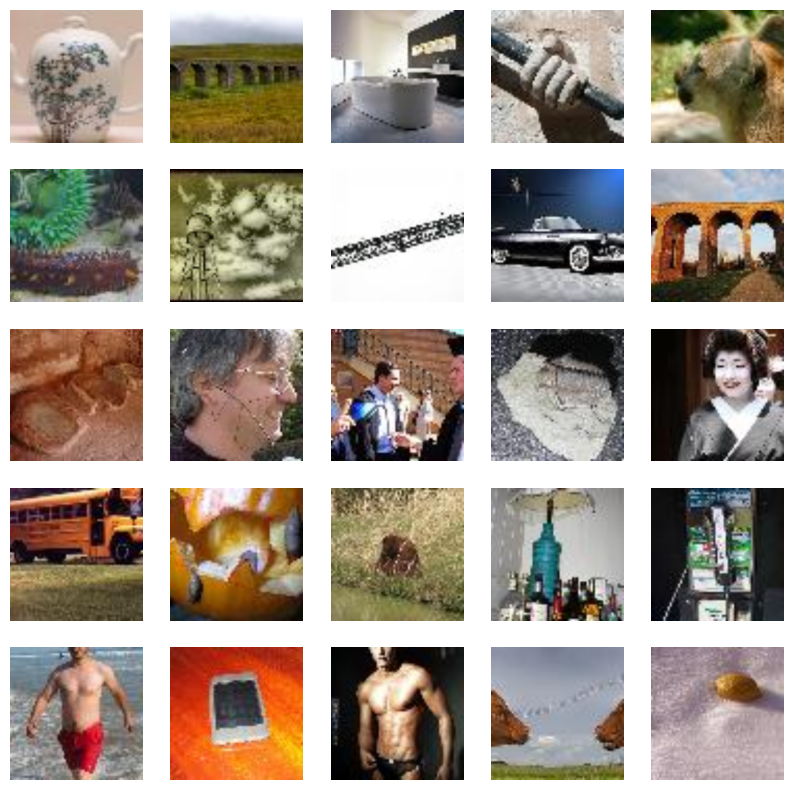

In [6]:
plt.figure(figsize=(10, 10))
for i in range(25):# Displaying the first 25 images as an example
    index = rd.randint(0, len(dataset)-1)
    plt.subplot(5, 5, i + 1)
    image = dataset[index][0].permute(1,2,0).numpy()
    plt.imshow(image)
    plt.axis('off')

plt.show()

In [8]:
class SimpleModel(nn.Module):
    def __init__(self, model_name, num_classes=200):
        super(SimpleModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Replace classifier with identity to get features from penultimate layer
        self.final_linear = nn.Linear(self.model.get_classifier().in_features, num_classes)
        self.model.classifier = nn.Identity()

    def forward(self, images):
        features = self.model(images)
        output = self.final_linear(features)
        return output  # Return raw logits

In [9]:
def criterion(outputs, targets):
    return nn.CrossEntropyLoss()(outputs, targets)

In [10]:
from sklearn.metrics import accuracy_score, recall_score
from torch.nn.functional import softmax

def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    running_corrects = 0.0
    running_recall = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, targets) in bar:
        # Move Data to Device
        images = images.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.long)  # Ensure targets are integer class labels
        
        batch_size = images.size(0)
        
        # Forward pass
        outputs = model(images)  # Raw logits of shape [batch_size, num_classes]
        
        # Compute the loss
        loss = criterion(outputs, targets)  # targets should be integers of shape [batch_size]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the optimizer
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()
        
        # Convert logits to class probabilities
        probs = softmax(outputs, dim=1).detach().cpu().numpy()
        targets_cpu = targets.cpu().numpy()
        
        # Get predicted classes
        preds = np.argmax(probs, axis=1)  # Shape [batch_size]
        
        # Compute metrics
        accuracy  = accuracy_score(targets_cpu, preds)
        recall    = recall_score(targets_cpu, preds, average='macro', zero_division=1)  # zero_division=1

        running_loss += (loss.item() * batch_size)
        running_corrects += (accuracy * batch_size)
        running_recall += (recall * batch_size)
        dataset_size += batch_size
        
        epoch_loss   = running_loss     / dataset_size
        epoch_acc    = running_corrects / dataset_size
        epoch_recall = running_recall   / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Acc=f"{epoch_acc:.2f}%", Train_Recall=f"{epoch_recall:.2f}%", Train_Loss=epoch_loss)
    
    return epoch_loss, epoch_acc, epoch_recall



In [11]:
# Disabling gradient computation and saving memory
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_corrects = 0.0
    running_recall = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, targets) in bar: 
        
        images = images.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.long)
        
        batch_size = images.size(0)

        outputs = model(images)
        
        # Compute the loss
        loss = criterion(outputs, targets)

        # Convert logits to class probabilities
        probs = softmax(outputs, dim=1).detach().cpu().numpy()
        targets_cpu = targets.cpu().numpy()
        
        # Get predicted classes
        preds = np.argmax(probs, axis=1)
        
        # Compute metrics
        accuracy = accuracy_score(targets_cpu, preds)
        recall   = recall_score(targets_cpu, preds, average='macro', zero_division=1)
        
        running_loss += (loss.item() * batch_size)
        running_corrects += (accuracy * batch_size)
        running_recall += (recall * batch_size)
        dataset_size += batch_size
        
        epoch_loss   = running_loss     / dataset_size
        epoch_acc    = running_corrects / dataset_size
        epoch_recall = running_recall   / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Acc=f"{epoch_acc:.2f}%", Train_Recall=f"{epoch_recall:.2f}%", Train_Loss=epoch_loss)
        
    return epoch_loss, epoch_acc, epoch_recall


In [12]:
import time

def run_training(model, optimizer, scheduler, device, num_epochs):
    # Confirm that it is running on GPU
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    
    # Deep copies the initial model weights to save the best model later
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # Initializes the best ACC to 0.
    best_epoch_accuracy = 0
    
    # Initializa dictionary (Better way than history = {} because history['Train Loss'].append(train_epoch_loss) is possible even is 'Train Loss' isn't a key yet)
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        print(f"EPOCH [{epoch}/{num_epochs}]")
        
        # Train for one epoch
        train_epoch_loss, train_epoch_acc, train_epoch_recall = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=device, epoch=epoch)
        # Valid for one epoch
        val_epoch_loss, val_epoch_acc, val_epoch_recall = valid_one_epoch(model, val_loader, device=device, 
                                         epoch=epoch)
        
        # Save the loss and score in the history dict
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Valid AUROC'].append(train_epoch_acc)
        history['Valid Acc'].append(val_epoch_acc)
        history['Train Recall'].append(train_epoch_recall)
        history['Valid Recall'].append(val_epoch_recall)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        # Save the model if it's getting better results
        if best_epoch_accuracy <= val_epoch_acc:
            print(f"{best_epoch_accuracy} Validation AUROC Improved ({best_epoch_accuracy} ---> {val_epoch_acc})")
            
            best_epoch_accuracy = val_epoch_acc
            
            # Deepcopy the weights
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # Saves the weights in the working directory
            PATH = "ACC_{:.2f}_Loss{:.4f}_epoch{:.0f}.bin".format(val_epoch_acc*100, val_epoch_loss, epoch)
            torch.save(model.state_dict(), PATH)
            
            print(f"Model Saved")
            
        print()
    
    end = time.time()
    
    # Display the training time
    time_elapsed = end - start # in seconds
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600 , (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best ACCURACY: {:.2%}".format(best_epoch_accuracy))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [13]:
simple_model = SimpleModel(model_name="tf_efficientnet_b0", num_classes= 200).to(device)

In [29]:
optimizer = Adam(simple_model.parameters(), lr=1e-4, weight_decay=1e-6)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=1400, eta_min=1e-6)

In [30]:
simple_model, history = run_training(
    simple_model,
    optimizer,
    scheduler,
    device=device,
    num_epochs=20
)

EPOCH [1/20]


100%|██████████| 63/63 [00:07<00:00,  8.65it/s, Epoch=1, Train_Acc=0.35%, Train_Loss=4.84, Train_Recall=0.58%]

0 Validation AUROC Improved (0 ---> 0.3455)
Model Saved

EPOCH [2/20]



100%|██████████| 63/63 [00:06<00:00,  9.10it/s, Epoch=2, Train_Acc=0.39%, Train_Loss=4.63, Train_Recall=0.60%]

0.3455 Validation AUROC Improved (0.3455 ---> 0.394)
Model Saved

EPOCH [3/20]



100%|██████████| 63/63 [00:06<00:00,  9.31it/s, Epoch=3, Train_Acc=0.40%, Train_Loss=4.61, Train_Recall=0.61%]

0.394 Validation AUROC Improved (0.394 ---> 0.4005)
Model Saved

EPOCH [4/20]



100%|██████████| 63/63 [00:07<00:00,  8.90it/s, Epoch=4, Train_Acc=0.42%, Train_Loss=4.53, Train_Recall=0.62%]

0.4005 Validation AUROC Improved (0.4005 ---> 0.42)
Model Saved

EPOCH [5/20]



100%|██████████| 63/63 [00:06<00:00,  9.33it/s, Epoch=5, Train_Acc=0.45%, Train_Loss=4.25, Train_Recall=0.63%]

0.42 Validation AUROC Improved (0.42 ---> 0.4465)
Model Saved

EPOCH [6/20]



100%|██████████| 63/63 [00:07<00:00,  8.72it/s, Epoch=6, Train_Acc=0.45%, Train_Loss=3.87, Train_Recall=0.63%]

0.4465 Validation AUROC Improved (0.4465 ---> 0.4545)
Model Saved

EPOCH [7/20]



100%|██████████| 63/63 [00:06<00:00,  9.17it/s, Epoch=7, Train_Acc=0.47%, Train_Loss=3.61, Train_Recall=0.64%]

0.4545 Validation AUROC Improved (0.4545 ---> 0.468)
Model Saved

EPOCH [8/20]



100%|██████████| 63/63 [00:06<00:00,  9.43it/s, Epoch=8, Train_Acc=0.47%, Train_Loss=3.52, Train_Recall=0.64%]

0.468 Validation AUROC Improved (0.468 ---> 0.4735)
Model Saved

EPOCH [9/20]



100%|██████████| 63/63 [00:06<00:00,  9.07it/s, Epoch=9, Train_Acc=0.47%, Train_Loss=3.53, Train_Recall=0.64%]


EPOCH [10/20]



100%|██████████| 63/63 [00:06<00:00,  9.16it/s, Epoch=10, Train_Acc=0.47%, Train_Loss=3.43, Train_Recall=0.64%]


EPOCH [11/20]



100%|██████████| 63/63 [00:07<00:00,  8.51it/s, Epoch=11, Train_Acc=0.49%, Train_Loss=3.21, Train_Recall=0.65%]

0.4735 Validation AUROC Improved (0.4735 ---> 0.4855)
Model Saved

EPOCH [12/20]



100%|██████████| 63/63 [00:06<00:00,  9.00it/s, Epoch=12, Train_Acc=0.49%, Train_Loss=2.98, Train_Recall=0.65%]

0.4855 Validation AUROC Improved (0.4855 ---> 0.492)
Model Saved

EPOCH [13/20]



100%|██████████| 63/63 [00:06<00:00,  9.21it/s, Epoch=13, Train_Acc=0.50%, Train_Loss=2.88, Train_Recall=0.65%]

0.492 Validation AUROC Improved (0.492 ---> 0.499)
Model Saved

EPOCH [14/20]



100%|██████████| 63/63 [00:06<00:00,  9.29it/s, Epoch=14, Train_Acc=0.50%, Train_Loss=2.86, Train_Recall=0.65%]

0.499 Validation AUROC Improved (0.499 ---> 0.5005)
Model Saved

EPOCH [15/20]



100%|██████████| 63/63 [00:06<00:00,  9.20it/s, Epoch=15, Train_Acc=0.50%, Train_Loss=2.82, Train_Recall=0.65%]


EPOCH [16/20]



100%|██████████| 63/63 [00:07<00:00,  8.66it/s, Epoch=16, Train_Acc=0.49%, Train_Loss=2.75, Train_Recall=0.65%]


EPOCH [17/20]



100%|██████████| 63/63 [00:07<00:00,  8.76it/s, Epoch=17, Train_Acc=0.51%, Train_Loss=2.63, Train_Recall=0.66%]

0.5005 Validation AUROC Improved (0.5005 ---> 0.512)
Model Saved

EPOCH [18/20]



100%|██████████| 63/63 [00:06<00:00,  9.20it/s, Epoch=18, Train_Acc=0.52%, Train_Loss=2.51, Train_Recall=0.66%]

0.512 Validation AUROC Improved (0.512 ---> 0.5185)
Model Saved

EPOCH [19/20]



100%|██████████| 63/63 [00:06<00:00,  9.22it/s, Epoch=19, Train_Acc=0.52%, Train_Loss=2.48, Train_Recall=0.66%]


EPOCH [20/20]



100%|██████████| 63/63 [00:06<00:00,  9.38it/s, Epoch=20, Train_Acc=0.52%, Train_Loss=2.49, Train_Recall=0.66%]


Training complete in 0h 51m 38s
Best ACCURACY: 51.85%
